# GDL - Regular Group Convolutions

## 0. Introduction

In this notebook, we will be implementing regular group convolutional networks from scratch, only making use of `pytorch` primitives. The goal is to get familiar with the practical considerations to take into account when actually implementing these convolutional networks. Questions and feedback may be forwarded to David Knigge; d.m.knigge@uva.nl.

If you'd like a refresher of the lecture, here we give a brief overview of the operations we are going to work with / implement. These will be treated more extensively below. For simplicity of notation, here we assume each CNN layer consists of only a single channel.

### 0.1 Brief recap on CNNs

Conventional CNNs make use of the convolution operator, here defined over $\mathbb{R}^2$ for a signal $f:\mathbb{R}^2 \rightarrow \mathbb{R}$ and a kernel $k: \mathbb{R}^2 \rightarrow \mathbb{R}$ at $\mathbf{x}\in \mathbb{R}^2$:

$$
(f * k) (\mathbf{x}) = 
    \int_{\mathbb{R}^2} f(\tilde{\mathbf{x}})k(\tilde{\mathbf{x}} - \mathbf{x}) \text{d}\tilde{\mathbf{x}},
$$

As we can see, the convolution operation comes down to an inner product of the function $f$ and a shifted kernel $k$. 

> Sidenote: In reality CNNs implement a discretised version of this operation;
$$
\begin{aligned}
(f*k) (\mathbf{x}) &= \sum_{\mathbf{\tilde{x}} \in \mathbb{Z}^2} f(\mathbf{\tilde{x}})k(\mathbf{x}-\mathbf{\tilde{x}})\Delta\mathbf{\tilde{x}}\\
&= \sum_{\mathbf{\tilde{x}} \in \mathbb{Z}^2} f(\mathbf{\tilde{x}})k(\mathbf{x}-\mathbf{\tilde{x}})
\end{aligned}
$$   
Where above, since pixels in an image are generally evenly spaced, we set $\Delta \mathbf{\tilde{x}}=1$. For this recap we stay in the continuous domain for simplicity.

In convolution layers, like PyTorch's `Conv2D` implementation, the above operation is carried out for every $\mathbf{x} \in \mathbb{Z}^2$ (limited of course to the domain over which the image is defined). Because the same set of weights is used throughout the input, the output of this operation is [equivariant](https://en.wikipedia.org/wiki/Convolution#Translational_equivariance) to transformations from the translation group $\mathbb{R}^2$. Furthermore $f,k$ usually consist of a number of channels, which are all summed over.


In this tutorial, we will use PyTorch's `torch.nn.functional.conv2d()` function to perform this integration operation at every position in input feature map. This saves us having to implement the convolution operation ourselves.


### 0.2 Brief recap on GCNNs

In regular group convolutions, the goal is to have a CNN of which are not only equivariant to translations $\mathbb{R}^2$, but which are also equivariant to another (usually broader) group of interest $G$. We focus specifically on groups which are combinations of translations $\mathbb{R}^2$ and some group of interest $H$. In this tutorial we keep to the group of 90 degree rotations in 2D; the [Cyclic group](https://en.wikipedia.org/wiki/Cyclic_group) of order 4 $H=C_4$. 

We will operate on 2D images, generally defined on $\mathbb{R}^2$, as such, the first step in constructing a network which can track under which _pose_ (read: transformation from a group $G=\mathbb{R}^2\rtimes H$) a feature in the input occurs, we need to transfer our signal to a domain in which the same feature under a different pose is disentangled. This happens through _the lifting convolution_, which maps features in our input signal $f_{in}:\mathbb{R}^2\rightarrow \mathbb{R}$ to a feature map on the group $f_{out}:G\rightarrow \mathbb{R}$. For a signal and kernel $f,k$ both defined on $\mathbb{R}^2$, and a group element $g=(\boldsymbol{x}, h) \in G=\mathbb{R}^2 \rtimes H$:

$$
(f *_{\text{lifting}} k) (g) = 
\int_{\mathbb{R}^2} f(\tilde{\mathbf{x}})k_h(\tilde{\mathbf{x}} - \mathbf{x}) \,{\rm d}\tilde{\mathbf{x}}.
$$

Where $k_h$ is the kernel $k:\mathbb{R}^2 \rightarrow \mathbb{R}$ transformed under the regular representation $\mathcal{L}_h$ of a group element $h \in H$; $k_h = \frac{1}{| h|}\mathcal{L}_{h}[k]$.

> Sidenote:
The factor $\frac{1}{| h|}$, with $|h|$ the determinant of the matrix representation of $h$ in $\mathbb{R}^2$, accounts for a possible change in volume on $\mathbb{R}^2$ that $h$ might have. Working with the cyclic group, we don't encounter this problem (the determinant of a rotation matrix is 1, volumes are invariant to rotations on $\mathbb{R}^2$), but if you'd like to implement equivariance to for example the dilation group, this becomes important.

Next, now that we have a feature map defined on the group; $f_{out}:G\rightarrow \mathbb{R}$, we apply group convolutions, extending the convolution operation to an integral over the entire group $G$;

$$
\begin{aligned}
(f *_{\mathrm{group}} k) (g) &=\int_G f(\tilde{g})k(g^{-1} \cdot \tilde{g}) {\rm d}\tilde{g} \\
&=\int_{\mathbb{R}^2}\int_H f(\tilde{\mathbf{x}}, \tilde{h})\mathcal{L}_{x}\mathcal{L}_{h}k(\tilde{\mathbf{x}}, \tilde{h})\dfrac{1}{|h|} \,{\rm d}\mathbf{\tilde{x}}\,{\rm d}\tilde{h}\\
&=\int_{\mathbb{R}^2}\int_H f(\tilde{\mathbf{x}},\tilde{h})k({h^{-1}}(\tilde{\mathbf{x}}-\mathbf{x}), h^{-1}\cdot \tilde{h})\dfrac{1}{|h|} \,{\rm d}\mathbf{\tilde{x}}\,{\rm d}\tilde{h}.
\end{aligned}
$$

The main difference with the lifting convolution is that the signal and kernel $f,k$ are both functions on $G$;$G\rightarrow \mathbb{R}$, and the integral reflects this by extending over the entire group $G$. Other than that, there is little difference!

After a number of such group convolutional layers, we will want to ultimately obtain a representation that is invariant to the group action. We can do this by performing a projection which collapses our function defined over $G$ to a single point, with an operation that is invariant to the group action (summing, averaging, max, min).

After this short refresher, let's get to coding!

### 0.3 Installing and importing some useful packages

Here we install and import some libraries that we will use throughout this tutorial. We use the `pytorch` as our deep learning framework of choice. Note that for ease of model training and tracking, we additionally make use of `pytorch-lightning`. Although the specifics of this package aren't the focus of this tutorial, if you'd like a refresher please have a look at this excellent [Deep Learning 1 tutorial by Phillip Lippe](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html#PyTorch-Lightning).

In [ ]:
## Standard libraries
import os
import numpy as np
import math
from PIL import Image
from types import SimpleNamespace
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
## Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
## PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip3 install pytorch-lightning>=1.4 --quiet
    import pytorch_lightning as pl
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [ ]:
# Path to the folder where the datasets are be downloaded (e.g. MNIST)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/DL2/GDL"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/DL2/GDL/"
# Files to download
pretrained_files = ["cnn-pretrained.ckpt", "gcnn-pretrained.ckpt", "paprika.tiff"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## 1. Group theory

### 1.1 What is a group?

To start off, we recap some of the group theoretical preliminaries that we saw in the first lecture of this module. Recall that a group is defined by a tuple $(G, \cdot)$, where $G$ is a set of group elements and $\cdot$ the binary group action which tells us how elements $g \in G$ combine. The group action $\cdot$ needs to satisfy:


1.   Closure. $G$ is closed under $\cdot$; for all $g_1, g_2 \in G$ we have $g_1 \cdot g_2 \in G$.
2.   Identity. There exists an identity element $e$ s.t. for each $g \in G$, we have $e \cdot g = g \cdot e = g$.
3.   Inverse. For every element $g \in G$ we have an element $g^{-1} \in G$, s.t. $g \cdot g^{-1} = e$.
4.   Associativity. For every set of elements $g_1, g_2, g_3 \in G$, we have ($g_1 \cdot g_2) \cdot g_3 = g_1 \cdot (g_2 \cdot g_3)$.

The group can have an action on functions defined on $\mathbb{R}^2$, which we can instantiate through the *regular representation* $\mathcal{L}_g^{\mathbb{G}\rightarrow \mathbb{R}^2}$. For simplicity, we write $\mathcal{L}_g$. It is given by:

$$
\mathcal{L}_g f (\mathbf{x}) = f(g^{-1} \cdot \mathbf{x})
$$

Where we write the action of $g^{-1}$ on $x$ as $g^{-1}\cdot \mathbf{x}$. This is where the regular group convolution gets its name; because of its use of the regular representation to transform the kernels $k$ used throughout the network.


### 1.2 Implementing a group in python

Let's start out with a baseclass in which we outline which functions we are going to need when working with groups in our setting. As we're going to use `torch` in our implementation of group convolutional neural networks, let us implement the group as a `torch` module as well.

We first specify a base class `GroupBase` in which we specify all necessary properties and operations that we need in our treatment of group convolutional neural networks. The idea is that in our implementation of group convolutions, implementing these functions is necessary and sufficient for extending group convolutional neural networks to other groups. In other words; if you'd like to implement group convolutions equivariant to a new group you find interesting, just inherit this baseclass, implement its methods, and you're good to go. (In practice this only faithfully works for discrete, compact groups).

In [ ]:
class GroupBase(torch.nn.Module):

    def __init__(self, dimension, identity):
        """ Implements a group.

        @param dimension: Dimensionality of the group (number of dimensions in the basis of the algebra).
        @param identity: Identity element of the group.
        """
        super().__init__()
        self.dimension = dimension
        self.register_buffer('identity', torch.Tensor(identity))

    def elements(self):
        """ Obtain a tensor containing all group elements in this group.
        
        """
        raise NotImplementedError()

    def product(self, h, h_prime):
        """ Defines group product on two group elements.

        @param g1: Group element 1
        @param g2: Group element 2
        """
        raise NotImplementedError()

    def inverse(self, h):
        """ Defines inverse for group element.

        @param g: A group element.
        """
        raise NotImplementedError()

    def left_action_on_R2(self, h_batch, x_batch):
        """ Group action of an element from the subgroup H on a vector in R2. For efficiency we
        implement this batchwise.

        @param h_batch: Group elements from H.
        @param x_batch: Vectors in R2.
        """
        raise NotImplementedError()

    def left_action_on_H(self, h_batch, h_prime_batch):
        """ Group action of elements of H on other elements in H itself. Comes down to group product.
        For efficiency we implement this batchwise. Each element in h_batch is applied to each element
        in h_prime_batch.

        @param h_batch: Group elements from H.
        @param h_prime_batch: Other group elements in H.        
        """
        raise NotImplementedError()

    def matrix_representation(self, h):
        """ Obtain a matrix representation in R^2 for an element h.

        @param h: Group element
        """
        raise NotImplementedError()

    def determinant(self, h):
        """ Calculate the determinant of the representation of a group element
        h.

        @param g:
        """
        raise NotImplementedError()
    
    def normalize_group_elements(self, h):
        """ Map the group elements to an interval [-1, 1]. We use this to create
        a standardized input for obtaining weights over the group.

        @param g:
        """
        raise NotImplementedError()

### 1.3 Implementing the cyclic group $\rm C_4$

As an example, let's discuss a relatively simple group; the group of all $90°$ rotations of the plane, otherwise known as the cyclic group $\rm C_4$. Note:



*   The set of group elements of $C_4$ is given by $G := \{ e, g, g^2, g^3\}$. We can parameterise these group elements using rotation angles $\theta$, i.e. $e=0, g=\frac{1}{2}\pi, g^2 = \pi$, ...
*   The group product is then given by $g \cdot g':= \theta + \theta' \mod 2 \pi$.
*   The inverse is given by: $g^{-1} = -\theta \mod 2\pi$.
*  The group $C_4$ has an action on the euclidean plane in 2 dimensions $\mathbb{R}^2$ given by a rotation matrix;
$$
R_{\theta}: \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta) \end{bmatrix}.
$$   
This gives us the regular representation $\mathcal{L}_\theta$ on functions $f$ defined over $\mathbb{R}^2$:
$$
\mathcal{L}_{\theta} f(\mathbf{x}) = f(R_{-\theta\mod2\pi}\mathbf{x}).
$$   

Let's implement this group!

In [ ]:
class CyclicGroup(GroupBase):

    def __init__(self, order):
        super().__init__(
            dimension=1,
            identity=[0.]
        )

        assert order > 1
        self.order = torch.tensor(order)

    def elements(self):
        """ Obtain a tensor containing all group elements in this group.
        
        """
        return torch.linspace(
            start=0,
            end=2 * np.pi * float(self.order - 1) / float(self.order),
            steps=self.order,
            device=self.identity.device
        )
    
    def product(self, h1, h2):
        """ Defines group product on two group elements of the cyclic group C4.

        @param h1: Group element 1
        @param h2: Group element 2
        """

        # As we directly parameterize the group by its rotation angles
        return torch.remainder(h1 + h2, 2 * np.pi)

    def inverse(self, h):
        """ Defines group inverse for an element of the cyclic group C4.

        @param h: Group element
        """
        return torch.remainder(-h, 2 * np.pi)
    
    def left_action_on_R2(self, batch_h, batch_x):
        """ Group action of an element g on a set of vectors in R2.

        @param batch_h: Tensor of group elements.
        @param batch_x: Tensor of vectors in R2.
        """
        # Create a tensor containing representations of each of the group
        # elements in the input. Creates a tensor of size [batch_size, 2, 2].
        batched_rep = torch.stack([self.matrix_representation(h) for h in batch_h])

        # Transform the r2 input grid with each representation to end up with
        # a transformed grid of dimensionality [num_group_elements, spatial_dim_y,
        # spatial_dim_x, 2]. 
        out = torch.einsum('boi,ixy->bxyo', batched_rep, batch_x)

        # Afterwards (because grid_sample assummes our grid is y,x instead of x,y) 
        # we swap x and y coordinate values with a roll along final dimension.
        return out.roll(shifts=1, dims=-1)

    def left_action_on_H(self, batch_h, batch_h_prime):
        """ Group action of an element h on a set of group elements in H.
        Nothing more than a batchwise group product.

        @param batch_h: Tensor of group elements.
        @param batch_h_prime: Tensor of group elements to apply group product to.
        """
        # The elements in batch_h work on the elements in batch_h_prime directly,
        # through the group product. Each element in batch_h is applied to each element
        # in batch_h_prime.
        transformed_batch_h = self.product(batch_h.repeat(batch_h_prime.shape[0], 1),
                                           batch_h_prime.unsqueeze(-1))
        return transformed_batch_h

    def matrix_representation(self, h):
        """ Obtain a matrix representation in R^2 for an element h.

        @param h: A group element.
        """
        cos_t = torch.cos(h)
        sin_t = torch.sin(h)

        return torch.tensor([
            [cos_t, -sin_t],
            [sin_t, cos_t]
        ], device=self.identity.device)
    
    def normalize_group_elements(self, h):
        """ Normalize values of group elements to range between -1 and 1.
        The group elements range from 0 to 2pi * (self.order - 1) / self.order,
        so we normalize by 

        @param h: A group element.
        :return:
        """
        largest_elem = 2 * np.pi * (self.order - 1) / self.order

        return (2*h / largest_elem) - 1.

### 1.4 Visualizing the group action

Let's play around with the group implementation we have just created!

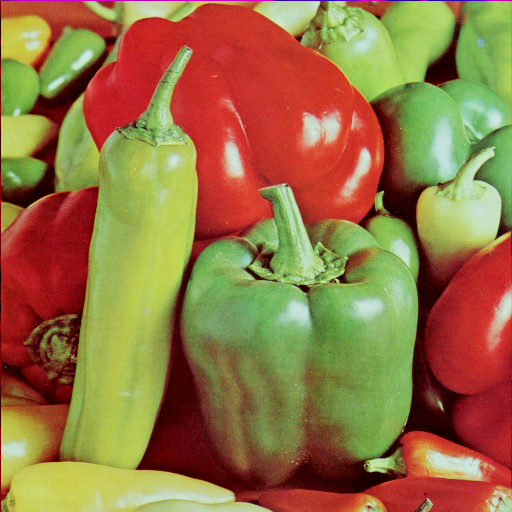

In [ ]:
img = Image.open(os.path.join(CHECKPOINT_PATH, "paprika.tiff"))

img_tensor = transforms.ToTensor()(img)

img

In [ ]:
# This creates a grid of the pixel locations in our image
img_grid_R2 = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, img_tensor.shape[-1]),
    torch.linspace(-1, 1, img_tensor.shape[-2]),
))

# [2, 512, 512] since our image is 2 dimensional and has a width and height of 
# 512 pixels
img_grid_R2.shape

torch.Size([2, 512, 512])

In [ ]:
# let's create the group of 90 degree clockwise rotations
c4 = CyclicGroup(order=4)
e, g1, g2, g3 = c4.elements()

In [ ]:
# What happens when we take the product of two rotations?
g = c4.product(g1, g2)

# Transform the image grid we just created with the matrix representation of 
# this group element. Note that we implemented this batchwise, so we add a dim.
transformed_grid = c4.left_action_on_R2(c4.inverse(g).unsqueeze(0), img_grid_R2)

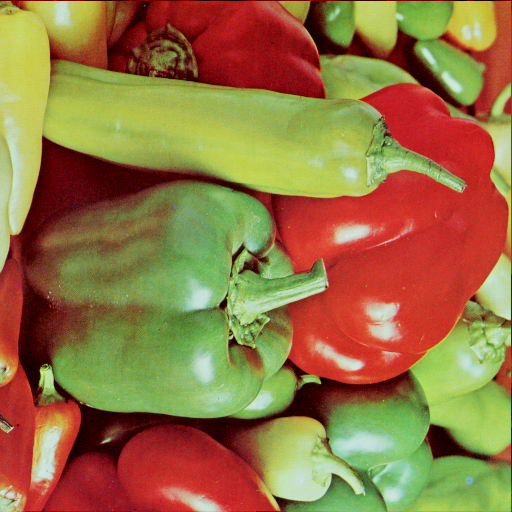

In [ ]:
# This function samples an input tensor based on a grid using interpolation. 
# It is implemented for batchwise operations so we add a dimension to our and input image.
transformed_img = torch.nn.functional.grid_sample(img_tensor.unsqueeze(0), transformed_grid, align_corners=True, mode="bilinear")

# if we turn this back into a PIL image we can see the result of our transformation!
transforms.ToPILImage()(transformed_img[0])

## 2. Group Equivariant Convolutional Networks

As discussed in the lecture, regular group convolutional neural networks consist of three main elements. The lifting convolution, group convolution and projection operation. We treat these in order.

### 2.1 Lifting convolution

First is the lifting convolution, which disentangles features at any spatial location in the input $f_{in}$ under transformations of $H$. You may think of this as registering at all locations, for a given feature $e$, the occurrences of transformed versions of this feature $\mathcal{L}_h(e)$, for $h \in H$. (Instead of $\mathcal{L}_h(e)$, we sometimes write $h \cdot e$ to denote the action of $h$ on $e$.) The lifting convolution thus maps from $\mathbb{R}^2$ to $G= \mathbb{R}^2 \rtimes H$. As a result, our lifted feature map $f_{out}$ has, besides the usual spatial dimensions, one or more additional group dimensions (dependent on the dimensionality of $H$).

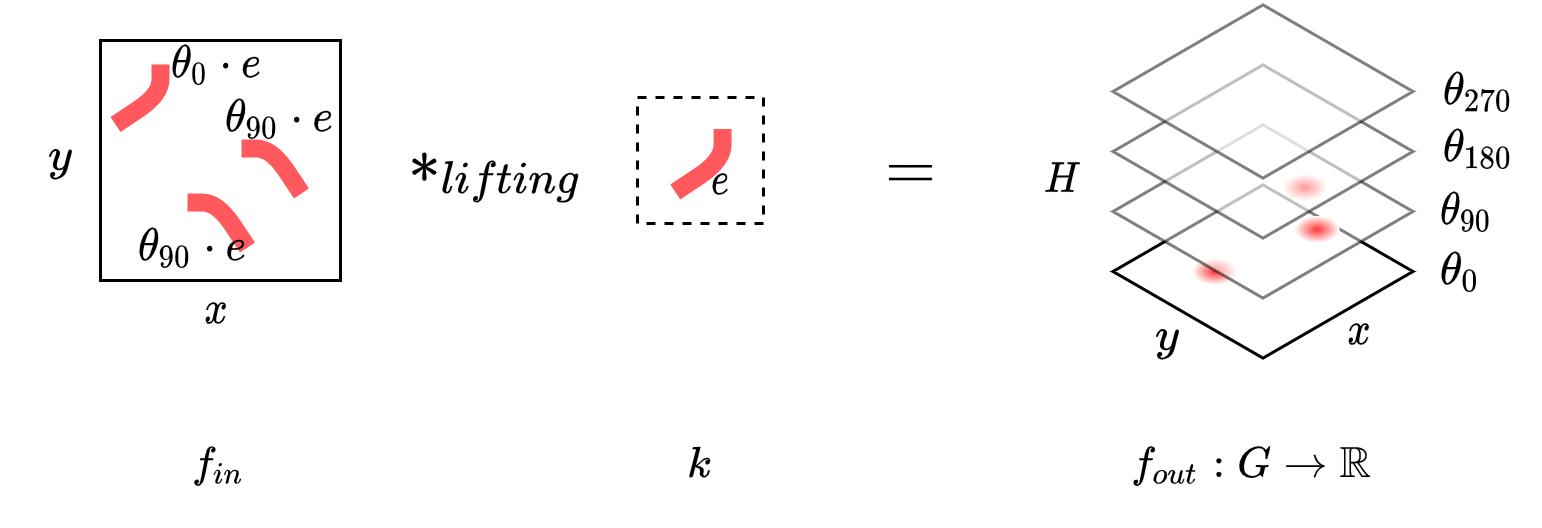

For example, take the group of 90 deg rotations as $H$, and let's say $e$ is a squiggle of sorts, of which we have three occurences in our input feature map $f_{in}$. Two are under a 90 deg rotation; $\theta_{90}\cdot e$, and one is under its canonical orientation; $\theta_0 \cdot e$. A lifting convolution with a kernel $k$ which exactly matches the feature $e$ would land responses at different offsets along the group dimension of the feature map; namely one at the spatial feature map corresponding to the group elements $\theta_0$ and two at the spatial feature map corresponding to $\theta_{90}$. See the above figure for an intuition.

### 2.1.1 Overview

How do we get our convolution operation to pick up features under different transformations of $H$? Intuitively, it is not that different from the convolution operation as we are familiar with in CNNs. There, we enable the extraction of features at any location by sharing the same kernel over all spatial positions.

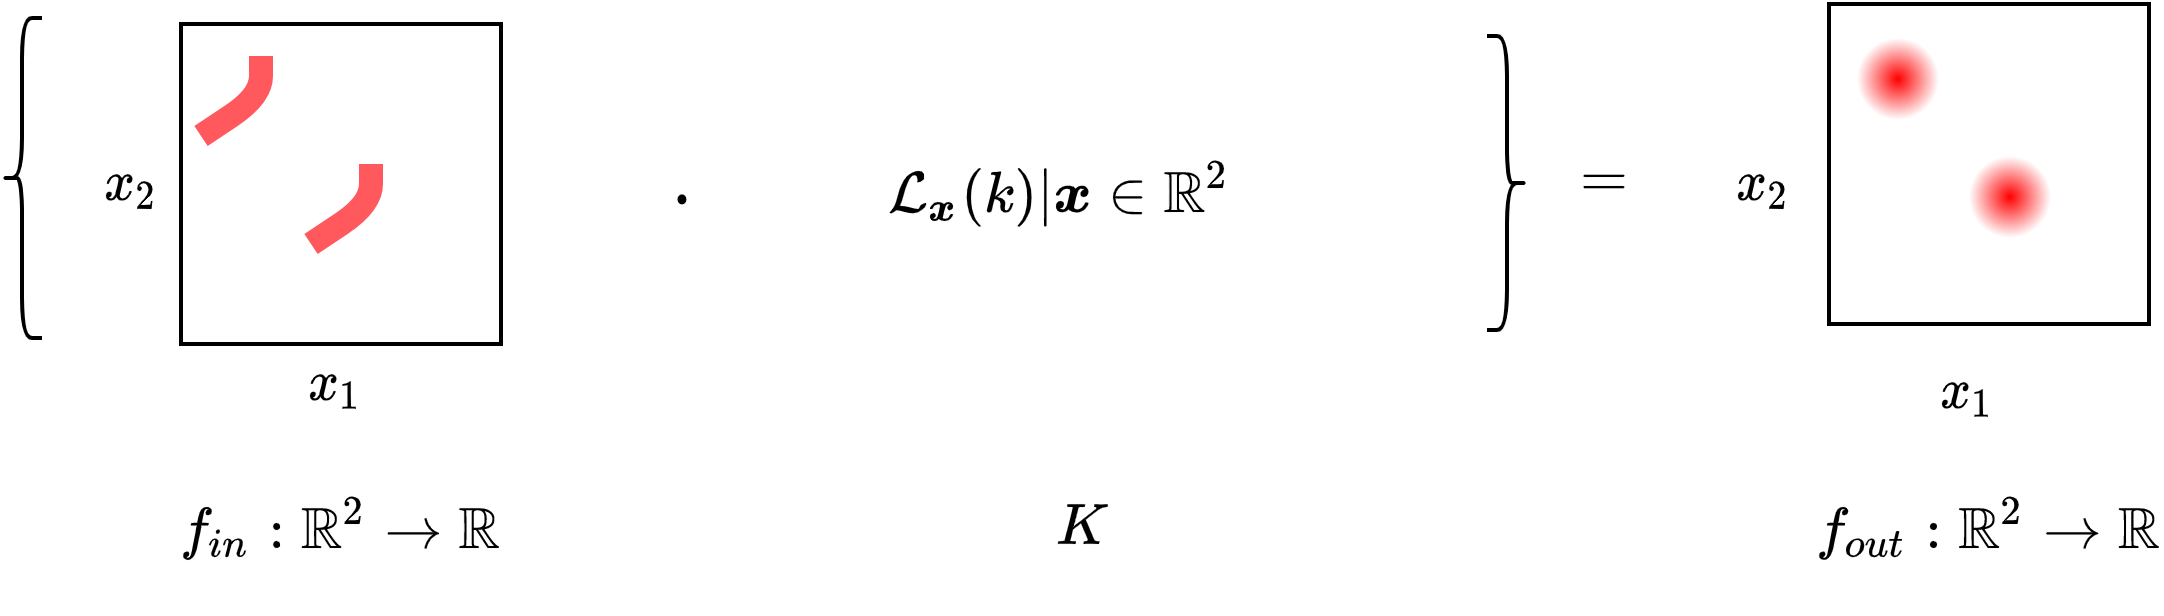


From our current group theoretic perspective, we interpret this as applying all possible translations $\boldsymbol{x} \in \mathbb{R}^2$ to our kernel $k$ and recording the response we get when we take the inner product of the input $f_{in}$ with this transformed kernel $\mathcal{L}_{\mathbf{x}} (k)$. This operation starts with a feature map defined on $\mathbb{R}^2$ and also yields a feature map defined over $\mathbb{R}^2$. See above.



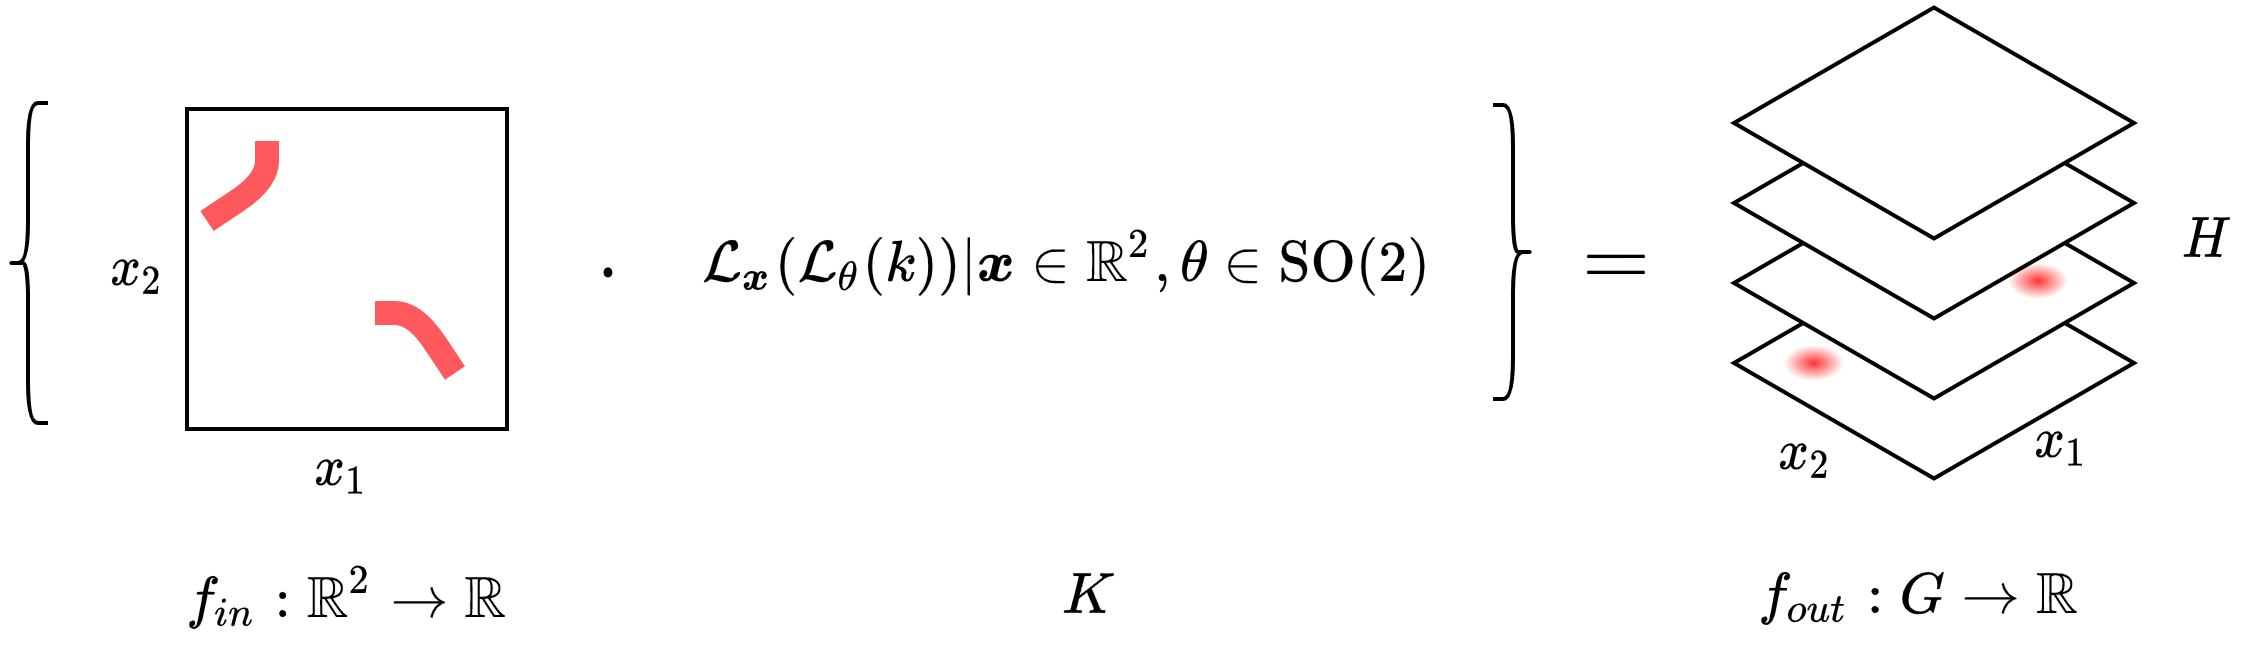

Now that we additionally want to register features under different group actions $\mathcal{L}_h$ for $h \in H$, we can do so by simply *also* transforming $k$ with all of their group actions and recording the results. For example, in case of the rotation group ${\rm C_4}$, we not only translate, but additionally rotate the kernel $k$ by all possible 90 deg rotations, and record the responses for the resulting transformed kernels!

#### 2.1.2 Implementing the lifting convolution kernel

Let's get to programming. First, we need to define a kernel $k$ which we can transform under arbitrary group actions with $\mathcal{L}_h$. When working with images, a convolution kernel is generally defined as a set of independently sampled weights $W$ defined over an equidistant discretisation of $\mathbb{R}^2$ (pixels are evenly spaced).

Recall that we can express the group action of a group $H$ on functions (such as kernels $k$) defined over $\mathbb{R}^2$ through the regular representation $\mathcal{L}_h$. The regular representation transforms the function $k$ through a transformation of the domain of the function $k$. In other words, the regular representation transforms the grid over which the kernel $k$ is defined, to obtain the values for the transformed function $\mathcal{L}_h(k)$.

As such, to define a kernel $k$ which we can transform with the regular representation of a group $H$, we need to construct a grid over which the kernel values are defined. We can then transform this grid by the action of each group element $h \in H$ to obtain a set of grids corresponding to transformed kernels for each of the group elements of $H$.  Let's get to work!

Notes:
*   In implementing the actual lifting and group convolution operations, we will make use of PyTorch's `Conv2D` class. This simplifies our life a lot, since `Conv2D` takes cares of translating the kernels $k$ over all input locations. Hence we do not need to implement the action of the translation group ourselves ($\mathcal{L}_{\mathbf{x}}$), but will still remain translation equivariant! Making our operations compatible with `Conv2D` requires a small amount of trickery, but we will get to that later.

In [ ]:
class LiftingKernelBase(torch.nn.Module):
    
    def __init__(self, group, kernel_size, in_channels, out_channels):
        """ 
        
        """
        super().__init__()
        self.group = group

        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Create spatial kernel grid. These are the coordinates on which our
        # kernel weights are defined.
        self.register_buffer("grid_R2", torch.stack(torch.meshgrid(
            torch.linspace(-1, 1, self.kernel_size),
            torch.linspace(-1, 1, self.kernel_size),
        )).to(self.group.identity.device))

        # Transform the grid by the elements in this group.
        self.register_buffer("transformed_grid_R2", self.create_transformed_grid_R2())

    def create_transformed_grid_R2(self):
        """Transform the created grid by the group action of each group element.
        This yields a grid (over H) of spatial grids (over R2). In other words,
        a list of grids, each index of which is the original spatial grid transformed by
        a corresponding group element in H.
        
        """
        # Obtain all group elements.
        group_elements = self.group.elements()

        # Transform the grid defined over R2 with the sampled group elements.
        transformed_grid = self.group.left_action_on_R2(
            self.group.inverse(group_elements),
            self.grid_R2
        )
        return transformed_grid


    def sample(self, sampled_group_elements):
        """ Sample convolution kernels for a given number of group elements

        arguments should include:
        :param sampled_group_elements: the group elements over which to sample
            the convolution kernels

        should return:
        :return kernels: filter bank extending over all input channels, 
            containing kernels transformed for all output group elements.
        """
        raise NotImplementedError()


In [ ]:
# Let's visualize the transformed kernel grids!
lifting_kernel_base = LiftingKernelBase(
    group=CyclicGroup(order=4),
    kernel_size=7,
    in_channels=1,
    out_channels=1
)

transformed_grid_R2 = lifting_kernel_base.transformed_grid_R2

# The grid has a shape of [num_group_elements, kernel_size, kernel_size, dim_fmap_domain(R^2)]
transformed_grid_R2.shape

torch.Size([4, 7, 7, 2])

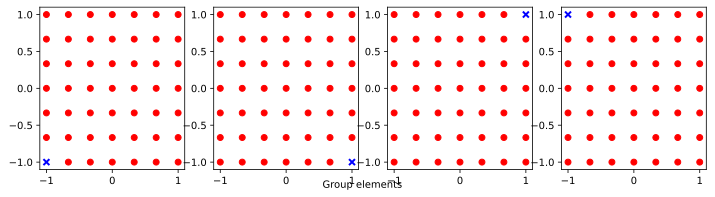

In [ ]:
plt.rcParams['figure.figsize'] = [12, 3]

# Create [group_elements] figures
fig, ax = plt.subplots(1, transformed_grid_R2.shape[0])

# Fold both spatial dimensions into a single dimension
transformed_grid_R2 = transformed_grid_R2.reshape(transformed_grid_R2.shape[0],
                                                  transformed_grid_R2.shape[1]*transformed_grid_R2.shape[2],
                                                  2).numpy()

# Visualize the transformed kernel grids. We mark the same cornerpoint by a blue 'x' in all grids as reference point.
for group_elem in range(transformed_grid_R2.shape[0]):
    ax[group_elem].scatter(transformed_grid_R2[group_elem, 0, 0], transformed_grid_R2[group_elem, 0, 1], marker='x', c='b')
    ax[group_elem].scatter(transformed_grid_R2[group_elem, 1:, 0], transformed_grid_R2[group_elem, 1:, 1], c='r')

fig.text(0.5, 0.04, 'Group elements', ha='center')

plt.show()

The grid transforms under the group action! Pretty cool.

At this point we have a set of grids transformed under the operation of the group $H$. We now need to decide how we are going to sample kernel values at the grid points in each of these grids. This is where the first major hurdle in applying GCNNs occurs.

Whereas conventional CNNs get away with sharing the same set of weights over all spatial positions (which is due to the fact that we translate the kernel only with steps that match whole pixel-distances), for arbitrary groups $H$ we may require kernel values for grid points that lie off the pixel grid of the kernel under its canonical transformation.

Of course, we could (and in fact will) use interpolation to obtain kernel values for grid locations between pixel locations, but this may be limiting in expressivity and will introduce interpolation artefacts!


Notes:

*  When we are implementing equivariance for the group of 90 deg rotations, $H=C_4$, we of course could get away without using interpolation, since all transformed grids lie share the same locations. We could implement the group action of this particular group through a permutation of the weights. But we'd like to be more general than that in this tutorial, so we'll go with interpolation instead! Luckily PyTorch has a function that allows us to sample an input on a grid; we will use PyTorch's `grid_sample` function for interpolation!

In [ ]:
class InterpolativeLiftingKernel(LiftingKernelBase):

    def __init__(self, group, kernel_size, in_channels, out_channels):
        super().__init__(group, kernel_size, in_channels, out_channels)

        # create and initialise a set of weights, we will interpolate these
        # to create our transformed spatial kernels.
        self.weight = torch.nn.Parameter(torch.zeros((
            self.out_channels,
            self.in_channels,
            self.kernel_size,
            self.kernel_size
        ), device=self.group.identity.device))

        # Initialize weights using kaiming uniform intialisation
        torch.nn.init.kaiming_uniform_(self.weight.data, a=math.sqrt(5))
    
    def sample(self):
        """ Sample convolution kernels for a given number of group elements

        should return:
        :return kernels: filter bank extending over all input channels, 
            containing kernels transformed for all output group elements.
        """
        # We fold the output channel dim into the input channel dim; this allows
        # us to use the torch grid_sample function.
        weight = self.weight.view(
            1,
            self.out_channels * self.in_channels,
            self.kernel_size,
            self.kernel_size
        )

        # We want a transformed set of weights for each group element so 
        # we repeat the set of spatial weights along the output group axis
        weight = weight.repeat(self.group.elements().numel(), 1, 1, 1)

        # Sample the transformed kernels
        transformed_weight = torch.nn.functional.grid_sample(
            weight,
            self.transformed_grid_R2,
            mode='bilinear',
            padding_mode='zeros',
            align_corners=True
        )

        # Separate input and output channels
        transformed_weight = transformed_weight.view(
            self.group.elements().numel(),
            self.out_channels,
            self.in_channels,
            self.kernel_size,
            self.kernel_size
        )

        # Put the output channel dimension before the output group dimension.
        transformed_weight = transformed_weight.transpose(0, 1)

        return transformed_weight

In [ ]:
ik = InterpolativeLiftingKernel(
    group=CyclicGroup(order=4),
    kernel_size=5,
    in_channels=2,
    out_channels=1
)

weights = ik.sample()

Let's visualize the weights we sampled from our lifting convolution kernel!

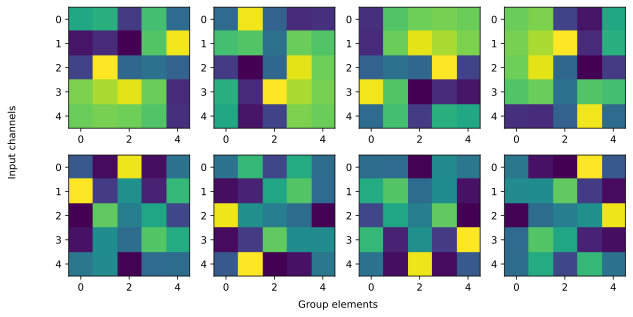

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]

# pick an output channel to visualize
out_channel_idx = 0

# create [in_channels, group_elements] figures
fig, ax = plt.subplots(weights.shape[2], weights.shape[1])

for in_channel in range(weights.shape[2]):
    for group_elem in range(weights.shape[1]):
        ax[in_channel, group_elem].imshow(
            weights[out_channel_idx, group_elem, in_channel, :, :].detach().numpy()
        )

fig.text(0.5, 0.04, 'Group elements', ha='center')
fig.text(0.04, 0.5, 'Input channels', va='center', rotation='vertical')

plt.show()

As we can see, spatial kernel rotates under the action of the rotation group elements!

#### 2.1.3 Implementing the lifting convolution

Finally, we can implement the lifting convolution operation! This class should take as input a feature map defined over $\mathbb{R}^2$, and spit out a feature map over $\mathbb{R}^2\rtimes H$, where features under different transformations $h \in H$ are disentangled along the $H$ axis!

Notes: 

*  To prevent having to implement our own implementation of the convolution operation, and to leverage the highly optimized pytorch `Conv2D` class, we use some neat tricks in our lifting (and group) convolution classes. Normally, a convolution layer applies a set of $n$ spatial kernels throughout the input, where $n$ is the number of output channels of the convolution operation. Because we now also have `num_group_elem` transformed versions of these kernels, which we want to apply everywhere in the input, we can trick PyTorch by having it treat every transformation of the same spatial kernel as a separate output channel. To do this, we simply reshape our set of `[out_channels, num_group_elem, in_channels, kernel_size, kernel_size]` kernels into a set of  `[out_channels x num_group_elem, in_channels, kernel_size, kernel_size]` kernels. See below!
*   As mentioned, a great additional benefit of using the PyTorch `Conv2D` class is that we are not required to obtain translated kernels $\mathcal{L}_{\mathbf{x}}(k)$ ourselves, PyTorch takes care of that!

In [ ]:
class LiftingConvolution(torch.nn.Module):

    def __init__(self, group, in_channels, out_channels, kernel_size):
        super().__init__()

        self.kernel = InterpolativeLiftingKernel(
            group=group,
            kernel_size=kernel_size,
            in_channels=in_channels,
            out_channels=out_channels
        )

    def forward(self, x):
        """ Perform lifting convolution

        @param x: Input sample [batch_dim, in_channels, spatial_dim_1, 
            spatial_dim_2]
        @return: Function on a homogeneous space of the group
            [batch_dim, out_channels, num_group_elements, spatial_dim_1, 
            spatial_dim_2]
        """

        # obtain convolution kernels transformed under the group
        conv_kernels = self.kernel.sample()

        # apply lifting convolution, note that the reshape folds the group 
        # dimension of the kernel into the output channel dimension.
        # Do you see why we (can) do this?
        x = torch.nn.functional.conv2d(
            input=x,
            weight=conv_kernels.reshape(
                self.kernel.out_channels * self.kernel.group.elements().numel(),
                self.kernel.in_channels,
                self.kernel.kernel_size,
                self.kernel.kernel_size
            ),
        )

        # reshape [batch_dim, in_channels * num_group_elements, spatial_dim_1, 
        # spatial_dim_2] into [batch_dim, in_channels, num_group_elements, 
        # spatial_dim_1, spatial_dim_2], separating channel and group 
        # dimensions.
        x = x.view(
            -1,
            self.kernel.out_channels,
            self.kernel.group.elements().numel(),
            x.shape[-1],
            x.shape[-2]
        )

        return x


In [ ]:
lifting_conv = LiftingConvolution(
    group=CyclicGroup(order=4),
    kernel_size=5,
    in_channels=3,
    out_channels=8
)

### 2.2 Group convolution

Now that we have a way to obtain feature maps defined over the group $G$ from input functions defined over $\mathbb{R}^2$, let's move on to implementing a convolutional layer that fully operates on the group $G: \mathbb{R}^2 \rtimes H$. Note that the input feature map at this stage, $f_{in}$, has, besides the usual spatial dimensions defined over $\mathbb{R}^2$, one or more additional group dimensions defined over $H$. As such, the group convolution operation, $*_{group}$, maps from a function on the group $f_{in}$ to another function on the group $f_{out}$.



#### 2.2.1 Overview

Since the input to the group convolution layer now contains additional group dimensions; $f_{in}: \mathbb{R}^2 \rtimes H \rightarrow \mathbb{R}$, we need to convolve it with a kernel $k_{group}$ that is also defined over the entire group; $k_{group}: \mathbb{R}^2 \rtimes H \rightarrow \mathbb{R}$. This is in contrast to the lifting convolution, where $k_{lifting}$ was only defined over the spatial domain $\mathbb{R}^2$. You could think of this kernel $k_{group}$ as a stack of spatial kernels, a separate one for each group element $h \in H$. Importantly, since $k$ is now *also* defined on a grid over $H$, the group $H$ now also has an action *on* this $H$-axis of $k$. For example, in our case of $H=C_4$, elements $\theta \in C_4$ now not only have a rotating action on the spatial domain of the kernel, but also a translating action along the group axis. Hence, applying a group element $\theta \in C_4$ leads to a twist-shift of the $k$ along the group axis. See below! (Remember $H=C_4$ is periodic)



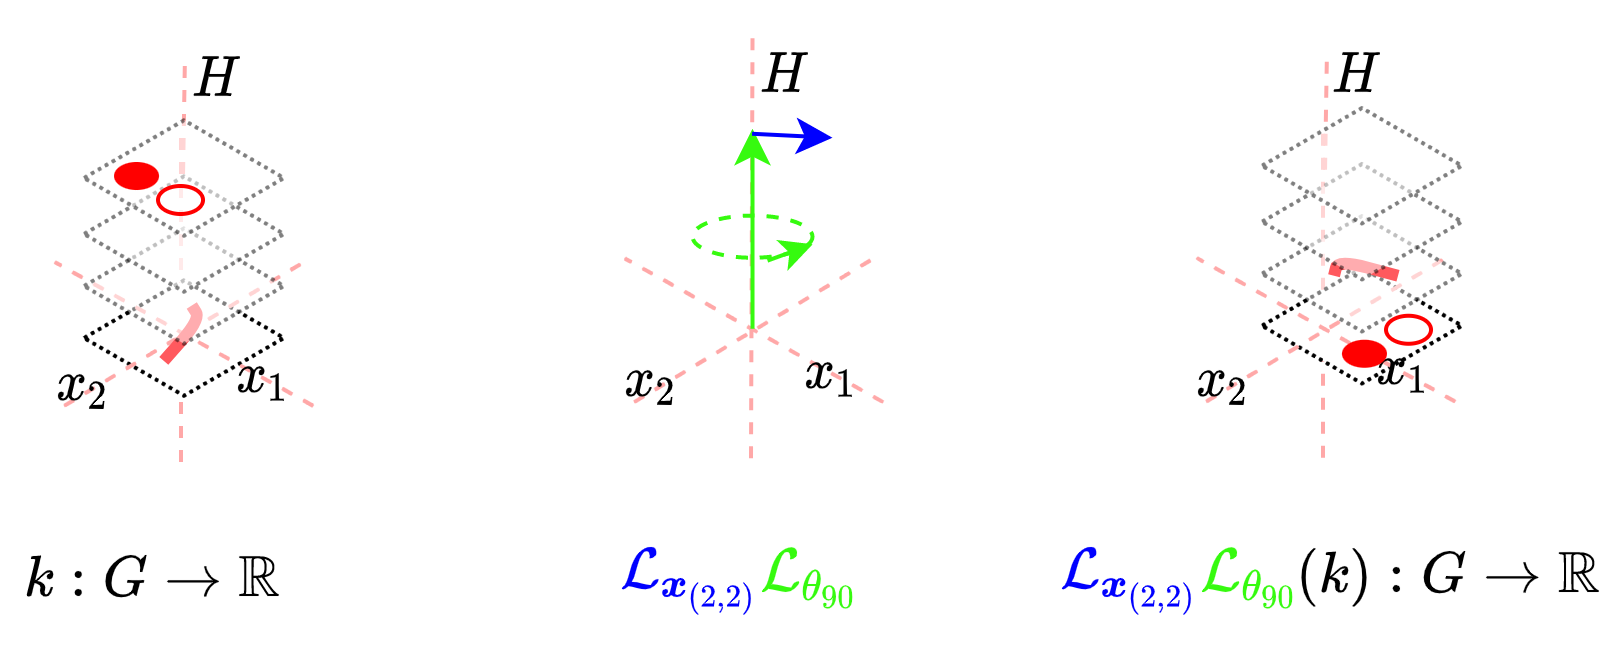


Apart from this difference, the group convolution operator works in much the same way as the liting operator. We again transform the kernel $k_{group}$ with the actions of the group $H$ and $\mathbb{R}^2$ and obtain responses for the inner product of this kernel with the input (although again, we let PyTorch do all the work for the translation group). See below for an intuition.


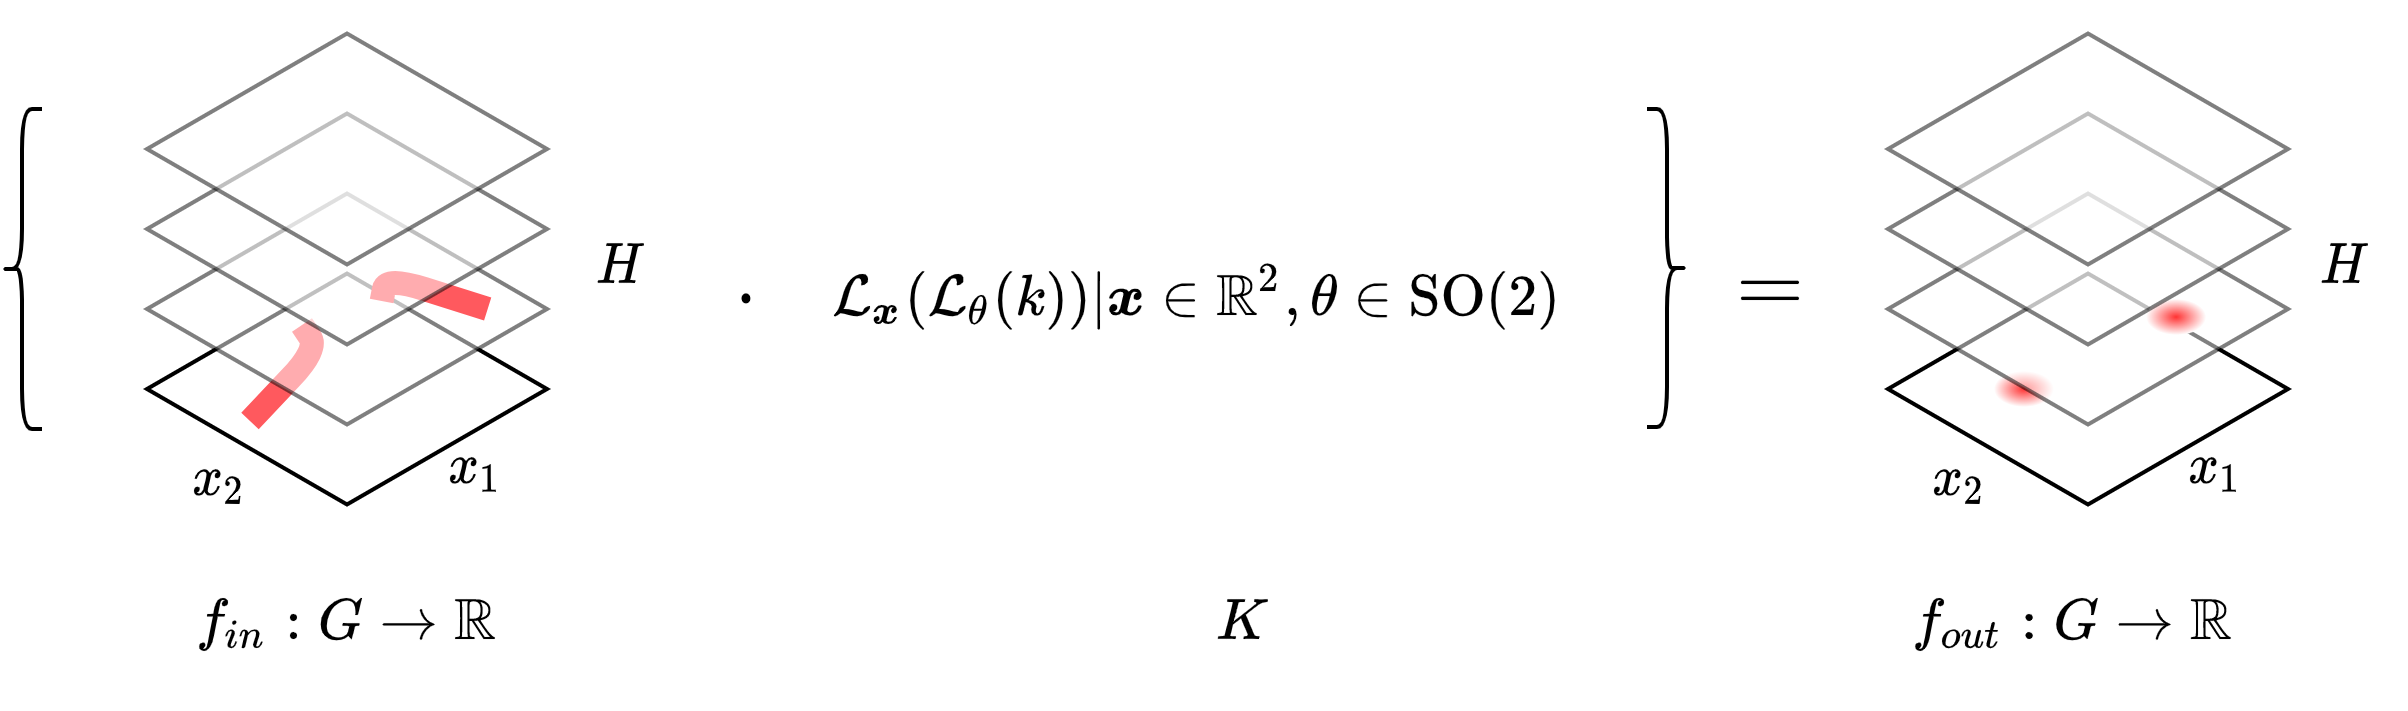

#### 2.2.2 Implementing the group convolution kernel

Again, let's define a kernel $k$ which we can transform with the group action. Now, our kernel grid is not only defined over $\mathbb{R}^2$, but additionally over $H$.

Notes:

*   Since the grid over $H$ is made up of elements $h'\in H$, transforming the grid over $H$ with (another) group element $h \in H$ comes out to applying the group product of $h$ with each grid element $h'$.
*   Because we are working with semidirect product groups $\mathbb{R}^2 \rtimes H$, we can transform the $\mathbb{R}^2$ and $H$ dimensions of our grids separately before combining them into a shared grid over $\mathbb{R}^2 \rtimes H$!

In [ ]:
class GroupKernelBase(torch.nn.Module):

    def __init__(self, group, kernel_size, in_channels, out_channels):
        """ 
        
        """
        super().__init__()
        self.group = group

        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Create a spatial kernel grid
        self.register_buffer("grid_R2", torch.stack(torch.meshgrid(
            torch.linspace(-1, 1, self.kernel_size),
            torch.linspace(-1, 1, self.kernel_size),
        )).to(self.group.identity.device))

        # The kernel grid now also extends over the group H, as our input 
        # feature maps contain an additional group dimension
        self.register_buffer("grid_H", self.group.elements())

        self.register_buffer("transformed_grid_R2xH", self.create_transformed_grid_R2xH())

    def create_transformed_grid_R2xH(self):
        """
        
        """
        # Sample the group
        group_elements = self.group.elements()

        # Transform the grid defined over R2 with the sampled group elements
        transformed_grid_R2 = self.group.left_action_on_R2(
            self.group.inverse(group_elements),
            self.grid_R2
        )

        # Transform the grid defined over H with the sampled group elements
        transformed_grid_H = self.group.left_action_on_H(
            self.group.inverse(group_elements), self.grid_H
        )

        # Rescale values to between -1 and 1, we do this to please the torch grid_sample
        # function.
        transformed_grid_H = self.group.normalize_group_elements(transformed_grid_H)

        # Create a combined grid as the product of the grids over R2 and H
        # repeat R2 along the group dimension, and repeat H along the spatial dimension
        # to create a [output_group_elem, num_group_elements, kernel_size, kernel_size, 3] grid
        transformed_grid = torch.cat(
            (
                transformed_grid_R2.view(
                    group_elements.numel(),
                    1,
                    self.kernel_size,
                    self.kernel_size,
                    2,
                ).repeat(1, group_elements.numel(), 1, 1, 1),
                transformed_grid_H.view(
                    group_elements.numel(),
                    group_elements.numel(),
                    1,
                    1,
                    1,
                ).repeat(1, 1, self.kernel_size, self.kernel_size, 1, )
            ),
            dim=-1
        )
        return transformed_grid


    def sample(self, sampled_group_elements):
        """ Sample convolution kernels for a given number of group elements

        arguments should include:
        :param sampled_group_elements: the group elements over which to sample
            the convolution kernels

        should return:
        :return kernels: filter bank extending over all input channels, 
            containing kernels transformed for all output group elements.
        """
        raise NotImplementedError()

Let's get some intuition for what is happening with our grid when we apply the group action of $H$ to it. First we will inspect the action on $\mathbb{R}^2$.

In [ ]:
group_kernel_base = GroupKernelBase(
    group=CyclicGroup(order=4),
    kernel_size=7,
    in_channels=1,
    out_channels=1
)

# Sample the group
group_elements = group_kernel_base.group.elements()

# Transform the grid defined over R2 with the sampled group elements
transformed_grid_R2 = group_kernel_base.group.left_action_on_R2(
    group_kernel_base.group.inverse(group_elements),
    group_kernel_base.grid_R2
)

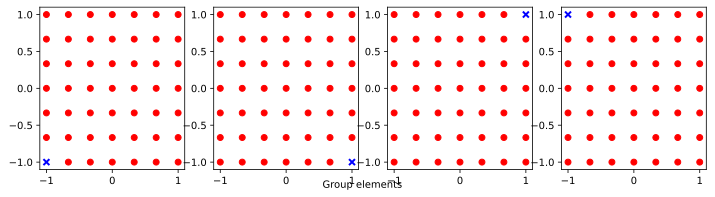

In [ ]:
plt.rcParams['figure.figsize'] = [12, 3]

# Create [group_elements] figures
fig, ax = plt.subplots(1, transformed_grid_R2.shape[0])

# Fold both spatial dimensions into a single dimension
transformed_grid_R2 = transformed_grid_R2.reshape(transformed_grid_R2.shape[0],
                                                  transformed_grid_R2.shape[1]*transformed_grid_R2.shape[2],
                                                  2).numpy()

# Visualize the transformed kernel grids. We mark the same cornerpoint by a blue 'x' in all grids as reference point.
for group_elem in range(transformed_grid_R2.shape[0]):
    ax[group_elem].scatter(transformed_grid_R2[group_elem, 0, 0], transformed_grid_R2[group_elem, 0, 1], marker='x', c='b')
    ax[group_elem].scatter(transformed_grid_R2[group_elem, 1:, 0], transformed_grid_R2[group_elem, 1:, 1], c='r')

fig.text(0.5, 0.04, 'Group elements', ha='center')

plt.show()

As we can see, this part of the grid, and what happens to it, is identical to the grid we saw in the lifting convolution. Note however, that this is only the spatial dimensions of the grid over which a group convolution kernel is defined. Let's move on to the grid over $H$.

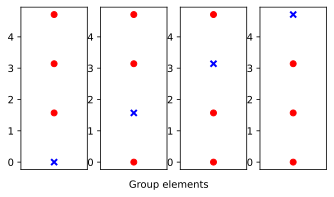

In [ ]:
plt.rcParams['figure.figsize'] = [5.5, 3]
# Transform the grid defined over H with the sampled group elements
transformed_grid_H = group_kernel_base.group.left_action_on_H(
    group_kernel_base.group.inverse(group_elements), group_kernel_base.grid_H
)

# Create [group_elements] figures
fig, ax = plt.subplots(1, transformed_grid_H.shape[0])

# Visualize the transformed kernel grids. We mark the same cornerpoint by a blue 'x' in all grids as reference point.
for group_elem in range(transformed_grid_H.shape[0]):
    ax[group_elem].scatter(torch.zeros_like(transformed_grid_H[group_elem, 0]), transformed_grid_H[group_elem, 0], marker='x', c='b')
    ax[group_elem].scatter(torch.zeros_like(transformed_grid_H[group_elem, 1:]), transformed_grid_H[group_elem, 1:], c='r')
    ax[group_elem].set_xticks([])

fig.text(0.5, 0.04, 'Group elements', ha='center')

# Remove the xticks, our group is 1D!
plt.show()

In our current setting, $H$ is one-dimensional, and as we can see, transforming the grid over $H$ with all group elements of $H$ leads to a translation over the group. Next, let's see what happens when we combine these grids.

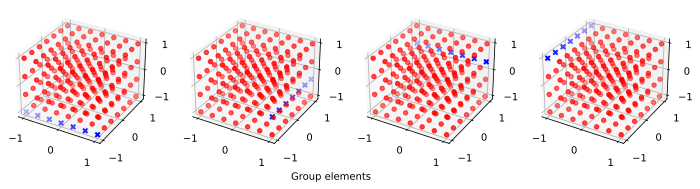

In [ ]:
plt.rcParams['figure.figsize'] = [12, 3]
transformed_grid_R2xH = group_kernel_base.transformed_grid_R2xH

# Create [group_elements] figures
fig, ax = plt.subplots(1, transformed_grid_H.shape[0], subplot_kw=dict(projection='3d'))

# Flatten spatial and group grid dimensions
transformed_grid_R2xH = transformed_grid_R2xH.reshape(transformed_grid_R2xH.shape[0], 
                                                      transformed_grid_R2xH.shape[1] * transformed_grid_R2xH.shape[2] * transformed_grid_R2xH.shape[3], 
                                                      transformed_grid_R2xH.shape[4])

# Visualize the transformed kernel grids. We mark the same row by a blue 'x' in all grids as reference point.
for group_elem in range(transformed_grid_R2xH.shape[0]):
    ax[group_elem].scatter(transformed_grid_R2xH[group_elem, 0:7, 0],
                           transformed_grid_R2xH[group_elem, 0:7, 1],
                           transformed_grid_R2xH[group_elem, 0:7, 2],
                           marker='x',
                           c='b')
    ax[group_elem].scatter(transformed_grid_R2xH[group_elem, 7:, 0],
                           transformed_grid_R2xH[group_elem, 7:, 1],
                           transformed_grid_R2xH[group_elem, 7:, 2],
                           c='r')

fig.text(0.5, 0.04, 'Group elements', ha='center')

plt.show()

As we can see, under the application of group elements $h' \in H$ the grid defined over $\mathbb{R}^2 \rtimes H$ rotates over the spatial dimensions, and shifts along the group dimension!

Let's now implement the group kernel using interpolation as well.

Notes:
*   Luckily, `grid_sample` also supports 3D inputs, so we can continue using it. 
*   For multidimensional groups $H$ the following implementation won't work, as this would require kernels defined on grids with dimensionality > 3, which `grid_sample` does not support. To resolve this, one could implement the sampling of the weights along the $H$ dimension using a translation of the weight matrix along the $H$ dimensions, and only interpolate over the spatial dimensions. This is possible because we don't end up between grid points along the group dimension $H$ (remember the closure constraint of the group product?).
*   The $C_4$ group exhibits periodicity along the group axis, so our kernels should too. Although we correctly implemented the group product to reflect this, `grid_sample` doesn't know about the periodicity of the weights in its interpolation. This shouldn't be a problem since, again because of the closure constraint, we should always end up exactly on grid points along the group axis, meaning no interpolation is necessary in that direction. In practice, because of the way `grid_sample` is implemented, we may encouter some small interpolation artefacts because of this.

In [ ]:
class InterpolativeGroupKernel(GroupKernelBase):

    def __init__(self, group, kernel_size, in_channels, out_channels):
        super().__init__(group, kernel_size, in_channels, out_channels)

        # create and initialise a set of weights, we will interpolate these
        # to create our transformed spatial kernels. Note that our weight
        # now also extends over the group H
        self.weight = torch.nn.Parameter(torch.zeros((
            self.out_channels,
            self.in_channels,
            self.group.elements().numel(), # this is different from the lifting convolution
            self.kernel_size,
            self.kernel_size
        ), device=self.group.identity.device))

        # initialize weights using kaiming uniform intialisation
        torch.nn.init.kaiming_uniform_(self.weight.data, a=math.sqrt(5))
    
    def sample(self):
        """ Sample convolution kernels for a given number of group elements

        should return:
        :return kernels: filter bank extending over all input channels, 
            containing kernels transformed for all output group elements.
        """

        # fold the output channel dim into the input channel dim; this allows
        # us to use the torch grid_sample function
        weight = self.weight.view(
            1,
            self.out_channels * self.in_channels,
            self.group.elements().numel(),
            self.kernel_size,
            self.kernel_size
        )

        # we want a transformed set of weights for each group element so 
        weight = weight.repeat(self.group.elements().numel(), 1, 1, 1, 1)

        # sample the transformed kernels, 
        transformed_weight = torch.nn.functional.grid_sample(
            weight,
            self.transformed_grid_R2xH,
            mode='bilinear',
            padding_mode='zeros',
            align_corners=True
        )

        # Separate input and output channels. Note we now have a notion of
        # input and output group dimensions in our weight matrix!
        transformed_weight = transformed_weight.view(
            self.group.elements().numel(), # Output group elements (like in the lifting convolutoin)
            self.out_channels,
            self.in_channels,
            self.group.elements().numel(), # Input group elements (due to the additional dimension of our feature map)
            self.kernel_size,
            self.kernel_size
        )

        # Put the output channel dimension before the output group dimension.
        transformed_weight = transformed_weight.transpose(0, 1)

        return transformed_weight

In [ ]:
ik = InterpolativeGroupKernel(
    group=CyclicGroup(order=4),
    kernel_size=5,
    in_channels=2,
    out_channels=8
)

In [ ]:
weights = ik.sample()
weights.shape

torch.Size([8, 4, 2, 4, 5, 5])

Let's visualize the sampled group convolution kernels! We visualize our 3D kernels in 2D by folding the input group dimension into the first spatial dimension. In doing so, we create a 2D flattened version of the 3D group convolution kernel, where spatial kernels corresponding to the different group elements lie along the spatial dimension. Each channel goes from `[num_group_elem, kernel_size, kernel_size]` to `[num_group_elem x kernel_size, kernel_size]`.

To clearly see what happens to the group convolution kernel under transformation of the group $H$, we outline the spatial kernel corresponding to the first input group element in red. For subsequent transformations we can see this spatial kernel. See below!

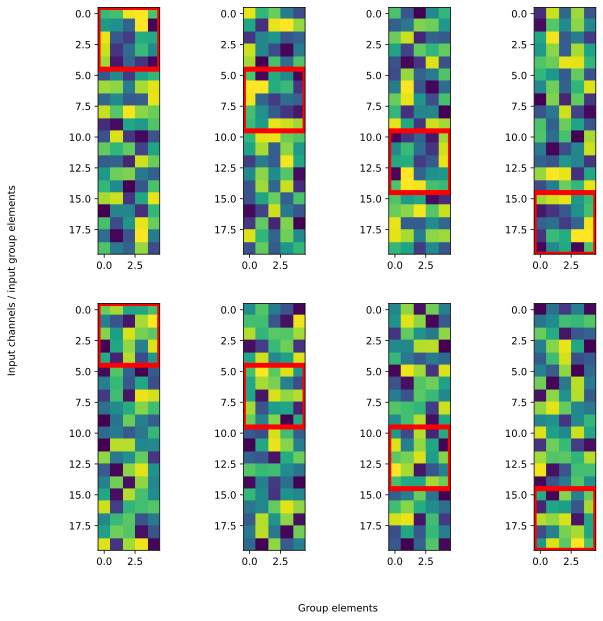

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]

# For ease of viewing, we fold the input group dimension into the spatial x dimension
weights_t = weights.view(
    weights.shape[0],
    weights.shape[1],
    weights.shape[2],
    weights.shape[3] * weights.shape[4],
    weights.shape[5]
)

# pick an output channel to visualize
out_channel_idx = 0

# create [in_channels, group_elements] figures
fig, ax = plt.subplots(weights.shape[2], weights.shape[1])

for in_channel in range(weights.shape[2]):
    for group_elem in range(weights.shape[1]):
        ax[in_channel, group_elem].imshow(
            weights_t[out_channel_idx, group_elem, in_channel, :, :].detach()
        )

        # Outline the spatial kernel corresponding to the first group element under canonical transformation
        rect = matplotlib.patches.Rectangle(
            (-0.5, group_elem * weights_t.shape[-1] - 0.5), weights_t.shape[-1], weights_t.shape[-1], linewidth=5, edgecolor='r', facecolor='none')
        ax[in_channel, group_elem].add_patch(rect)

fig.text(0.5, 0.04, 'Group elements', ha='center')
fig.text(0.04, 0.5, 'Input channels / input group elements', va='center', rotation='vertical')

plt.show()

We see the same twist shift motion as we saw with the kernel grids!

#### 2.2.3 Implementing the group convolution

The next step is implementing the group convolution operation. 

Notes:
*  We would still like to use PyTorch's `Conv2D` implementation, but we're now faced with an additional problem; the group dimension in the input feature map. Luckily we can resolve this problem in much the same way; normally a 2D convolution layer integrates over a local neighbourhood of all input channels. We would now additionally like to integrate over the entire group. Thus, we can simply treat the group dimensions in the input feature map as additional channel dimensions! We achieve this by folding our input group dimension into the input channel dimension; $f_{in}$ is reshaped from `[batch, in_channels, num_group_elem, spatial_1, spatial_2]` into `[batch, in_channels x num_group_elem, spatial_1, spatial_2]`.
*  To match this, and to apply the same trick as we did in the lifting convolution to get results for each separate group element in the *output*, we also reshape our kernel from `[out_channels, num_group_elem, in_channels, num_group_elem, kernel_size, kernel_size]` to `[out_channels x num_group_elem, in_channels x num_group_elem, kernel_size, kernel_size]`. See below!

In [ ]:
class GroupConvolution(torch.nn.Module):

    def __init__(self, group, in_channels, out_channels, kernel_size):
        super().__init__()

        self.kernel = InterpolativeGroupKernel(
            group=group,
            kernel_size=kernel_size,
            in_channels=in_channels,
            out_channels=out_channels
        )

    def forward(self, x):
        """ Perform lifting convolution

        @param x: Input sample [batch_dim, in_channels, group_dim, spatial_dim_1, 
            spatial_dim_2]
        @return: Function on a homogeneous space of the group
            [batch_dim, out_channels, num_group_elements, spatial_dim_1, 
            spatial_dim_2]
        """

        # We now fold the group dimensions of our input into the input channel
        # dimension
        x = x.reshape(
            -1,
            x.shape[1] * x.shape[2],
            x.shape[3],
            x.shape[4]
        )

        # We obtain convolution kernels transformed under the group
        conv_kernels = self.kernel.sample()

        # Apply group convolution, note that the reshape folds the group 
        # dimension of the kernel into the output channel dimension.
        # Do you see why we (can) do this?
        x = torch.nn.functional.conv2d(
            input=x,
            weight=conv_kernels.reshape(
                self.kernel.out_channels * self.kernel.group.elements().numel(),
                self.kernel.in_channels * self.kernel.group.elements().numel(),
                self.kernel.kernel_size,
                self.kernel.kernel_size
            ),
        )

        # Reshape [batch_dim, in_channels * num_group_elements, spatial_dim_1, 
        # spatial_dim_2] into [batch_dim, in_channels, num_group_elements, 
        # spatial_dim_1, spatial_dim_2], separating channel and group 
        # dimensions.
        x = x.view(
            -1,
            self.kernel.out_channels,
            self.kernel.group.elements().numel(),
            x.shape[-1],
            x.shape[-2],
        )

        return x


### 2.3 Projection to obtain invariance and tying everything together

Up until now, our feature maps equivary with the group action of $\mathbb{R}^2 \rtimes H$; our feature maps are defined over $\mathbb{R}^2 \rtimes H$. Usually in a CNN, a series of convolutional layers build a representation, which is followed by a (number of) linear layer(s). To create a GCNN using our lifting and group convolution operations that is fully invariant to the action of the group, we must apply a projection operation invariant to the action of the group to our feature map, to reduce its dimensionality from `[batch, channels, num_group_elem, spatial_1, spatial_2]` to `[batch, channels]` or even . The representation that we obtain then is fully invariant to the group. This representation is pushed through a final linear layer to yield a classification.

Below, we build a small GCNN from our implemented PyTorch modules.

Notes:
*   We use a mean-pooling operation to pool over group and spatial dimensions, but we could also use max or min pooling, or any other operation invariant to the group.

In [ ]:
class GroupEquivariantCNN(torch.nn.Module):

    def __init__(self, group, in_channels, out_channels, kernel_size, num_hidden, hidden_channels):
        super().__init__()

        # Create the lifing convolution.
        self.lifting_conv = LiftingConvolution(
            group=group,
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size
        )

        # Create a set of group convolutions.
        self.gconvs = torch.nn.ModuleList()
        for i in range(num_hidden):
            self.gconvs.append(
                GroupConvolution(
                    group=group,
                    in_channels=hidden_channels,
                    out_channels=hidden_channels,
                    kernel_size=kernel_size
                )
            )

        # Create the projection layer.
        self.projection_layer = partial(torch.mean, dim=(-3, -2, -1))

        # And a final linear layer for classification.
        self.final_linear = torch.nn.Linear(hidden_channels, out_channels)
    
    def forward(self, x):
        
        # Lift and disentangle features in the input.
        x = self.lifting_conv(x)
        x = torch.nn.functional.layer_norm(x, x.shape[-4:])
        x = torch.nn.functional.relu(x)

        # Apply group convolutions.
        for gconv in self.gconvs:
            x = gconv(x)
            x = torch.nn.functional.layer_norm(x, x.shape[-4:])
            x = torch.nn.functional.relu(x)
        
        # to ensure equivariance, apply max pooling over group and spatial dims
        x = self.projection_layer(x).squeeze()

        x = self.final_linear(x)
        return x

To compare, let's create a more or less identical CNN. The only difference here is that this network consists of regular convolution operations.

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, num_hidden, hidden_channels):
        super().__init__()

        self.first_conv = torch.nn.Conv2d(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size
        )

        self.convs = torch.nn.ModuleList()
        for i in range(num_hidden):
            self.convs.append(
                torch.nn.Conv2d(
                    in_channels=hidden_channels,
                    out_channels=hidden_channels,
                    kernel_size=kernel_size
                )
            )

        self.final_linear = torch.nn.Linear(hidden_channels, out_channels)
    
    def forward(self, x):

        x = self.first_conv(x)
        x = torch.nn.functional.layer_norm(x, x.shape[-3:])
        x = torch.nn.functional.relu(x)

        for conv in self.convs:
            x = conv(x)
            x = torch.nn.functional.layer_norm(x, x.shape[-3:])
            x = torch.nn.functional.relu(x)
        
        # apply average pooling over remaining spatial dimensions
        x = torch.nn.functional.adaptive_avg_pool2d(x, 1).squeeze()

        x = self.final_linear(x)
        return x

## 3. Experimenting with our implementation

Note that for ease of model training and tracking, we additionally make use of `pytorch-lightning`. Although the specifics of this package aren't the focus of this tutorial, if you'd like a refresher please have a look at this excellent [Deep Learning 1 tutorial by Phillip Lippe](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html#PyTorch-Lightning).



### 3.1 Generalization to the group action

To show the generalization capabilities of regular group convolutional networks, we will train this model on the MNIST training dataset, but evaluate it on an augmented version of the MNIST test set in which each image is randomly rotated by a continuous rotation between $[0, 2\pi]$.

In [ ]:
# We normalize the training data.
train_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                  ])

# To demonstrate the generalization capabilities our rotation equivariant layers bring, we apply a random
# rotation between 0 and 360 deg to the test set.
test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.RandomRotation(
                                                     [0, 360],
                                                     torchvision.transforms.InterpolationMode.BILINEAR,
                                                     fill=0),
                                                 torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                 ])

# We demonstrate our models on the MNIST dataset.
train_ds = torchvision.datasets.MNIST(root=DATASET_PATH, train=True, transform=train_transform, download=True)
test_ds = torchvision.datasets.MNIST(root=DATASET_PATH, train=False, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

# Set the random seed for reproducibility.
pl.seed_everything(12)

Global seed set to 12


12

Let's visualize some of the training and test images. As we can see the test images are randomly rotated.

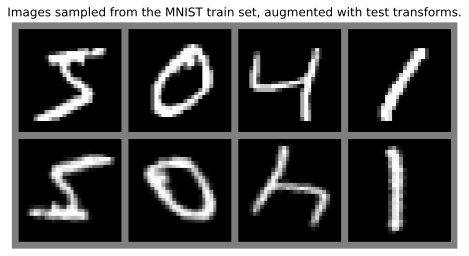

In [ ]:
NUM_IMAGES = 4
images = [train_ds[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_ds.data[idx].numpy()) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Images sampled from the MNIST train set, augmented with test transforms.")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
class DataModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
        optimizer = optim.AdamW(
            self.parameters(), **self.hparams.optimizer_hparams)
        return [optimizer], []

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc, prog_bar=True)

We create a dictionary to keep track of our models

In [ ]:
model_dict = {
    'CNN': CNN,
    'GCNN': GroupEquivariantCNN
}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

In [ ]:
def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         gpus=1 if str(device)=="cuda:0" else 0,                                             # We run on a single GPU (if possible)
                         max_epochs=10,                                                                      # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch")])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = DataModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(12) # To be reproducable
        model = DataModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = DataModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on test set
    val_result = trainer.test(model.to(device), test_loader, verbose=False)
    result = {"val": val_result[0]["test_acc"]}

    return model, result

Let's train the conventional CNN first!

In [ ]:
cnn_model, cnn_results = train_model(model_name="CNN",
                                     model_hparams={"in_channels": 1,
                                                    "out_channels": 10,
                                                    "kernel_size": 5,
                                                    "num_hidden":4,
                                                    "hidden_channels":32},
                                     optimizer_name="Adam",
                                     optimizer_hparams={"lr": 1e-2,
                                                        "weight_decay": 1e-4},
                                     save_name='cnn-pretrained')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Found pretrained model at ../../saved_models/DL2/GDL/cnn-pretrained.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/phillip/anaconda3/envs/dl2020/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

Next, we train the GCNN. Note that we reduce the number of channels by half to account for the increased kernel dimensionality. We do this to keep the number of trainable parameters more or less equal.

In [ ]:
gcnn_model, gcnn_results = train_model(model_name="GCNN",
                                       model_hparams={"in_channels": 1,
                                                      "out_channels": 10,
                                                      "kernel_size": 5,
                                                      "num_hidden": 4,
                                                      "hidden_channels":16, # to account for the increase in trainable parameters due to the extra dimension in our feature maps, remove some hidden channels.
                                                      "group":CyclicGroup(order=4).to(device)},
                                       optimizer_name="Adam",
                                       optimizer_hparams={"lr": 1e-2,
                                                          "weight_decay": 1e-4},
                                       save_name='gcnn-pretrained')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at ../../saved_models/DL2/GDL/gcnn-pretrained.ckpt, loading...


Testing: 0it [00:00, ?it/s]

In [ ]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

Let us inspect the final results from both models. As we can see the GCNN performs considerably better than the CNN. This because the GCNN implementation is invariant to rotations of 90 deg, which makes it able to recognize the handwritten digits in the test set under such rotations. Of course, since the test images are rotated by continuous rotations between 0 and 360 deg, the GCNN model still doesn't obtain perfect accuracy. How could we further improve the GCNNs generalization?

In [ ]:
import tabulate
from IPython.display import display, HTML
all_models = [
    ("CNN", cnn_results, cnn_model),
    ("GCNN", gcnn_results, gcnn_model),
]
table = [[model_name,
          f"{100.0*model_results['val']:4.2f}%",
          "{:,}".format(sum([np.prod(p.shape) for p in model.parameters()]))]
         for model_name, model_results, model in all_models]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Model", "Val Accuracy", "Num Parameters"])))

Model,Val Accuracy,Num Parameters
CNN,46.97%,"103,690"
GCNN,91.35%,"102,970"


### 3.2 Inspecting the created feature maps

To better understand what happens inside our CNN and GCNN as we rotate an input image, let's visualize a single channel of a feature map in the second layer of the network for different rotations of an input image.

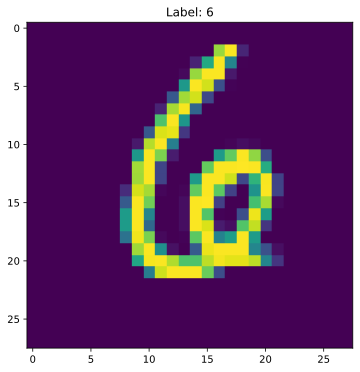

In [ ]:
train_ds = torchvision.datasets.MNIST(root=DATASET_PATH, train=False, transform=None)

# Get an image from the test dataset.
digit, label = train_ds[123]

# Turn it into a tensor
digit = transforms.ToTensor()(digit)

plt.figure(figsize=(6, 6))
plt.imshow(digit.squeeze())
plt.title(f'Label: {label}')
plt.show()

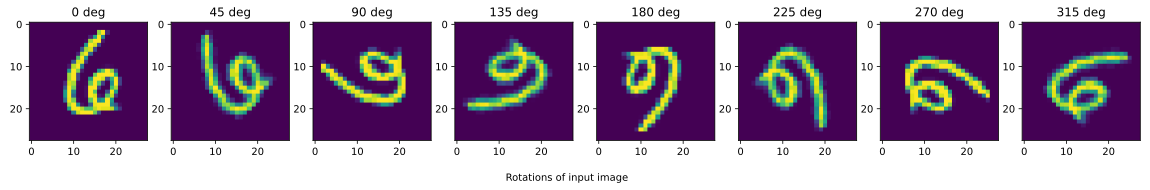

In [ ]:
plt.rcParams['figure.figsize'] = [20, 3]

# Get a set of angles by which to rotate this image.
rots = torch.linspace(0, 360 - 360/8, 8)

# Rotate the input image and push it through the normalization transform
rot_digit = torch.stack(tuple(torchvision.transforms.functional.rotate(digit, a.item(), torchvision.transforms.functional.InterpolationMode.BILINEAR) for a in rots))
rot_digit = torchvision.transforms.Normalize((0.1307,), (0.3081,))(rot_digit)

# Create a subfigure for every rotated input
fig, ax = plt.subplots(1, rots.numel())

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        rot_digit[idx, :, :].squeeze()
    )
    ax[idx].set_title(f"{int(rotation)} deg")

fig.text(0.5, 0.04, 'Rotations of input image', ha='center')

plt.show()

In [ ]:
# Forward it through the first few layers of the CNN
cnn_out = cnn_model.model.first_conv(rot_digit)
cnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(cnn_out, cnn_out.shape[-3:]))
for i in range(2):
    cnn_out = cnn_model.model.convs[i](cnn_out)
    cnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(cnn_out, cnn_out.shape[-3:]))

# Let's also see what happens after we apply projection over remaining spatial dimensions.
projected_cnn_out = torch.nn.functional.adaptive_avg_pool2d(cnn_out, 1).squeeze()

# Forward it through the first few layers of the GCNN
gcnn_out = gcnn_model.model.lifting_conv(rot_digit)
gcnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(gcnn_out, gcnn_out.shape[-4:]))
for i in range(2):
    gcnn_out = gcnn_model.model.gconvs[i](gcnn_out)
    gcnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(gcnn_out, gcnn_out.shape[-4:]))

# And let's see what happens if we apply the projection on this equivariant representation
projected_gcnn_out = torch.mean(gcnn_out, dim=(-3, -2, -1))

Let's first visualize the activations after the third convolution for a single channel of the regular CNN.

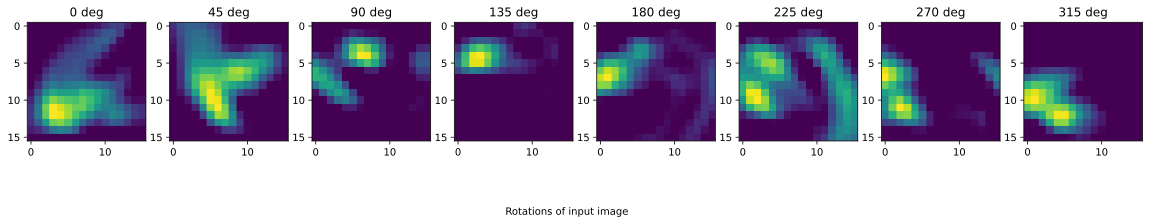

In [ ]:
plt.rcParams['figure.figsize'] = [20, 4]

# Pick a channel to visualize
channel_idx = 2

# Create a subfigure for every rotated input
fig, ax = plt.subplots(1, rots.numel())

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        cnn_out[idx, out_channel_idx, :, :].detach().numpy()
    )
    ax[idx].set_title(f"{int(rotation)} deg")

fig.text(0.5, 0.04, 'Rotations of input image', ha='center')

plt.show()

Representations change dramatically as the input rotates. To the CNN, each of these images are completely different. These representations are not equivariant to rotation.

Let's move on to visualizing a single channel of the GCNN after the second gconv.

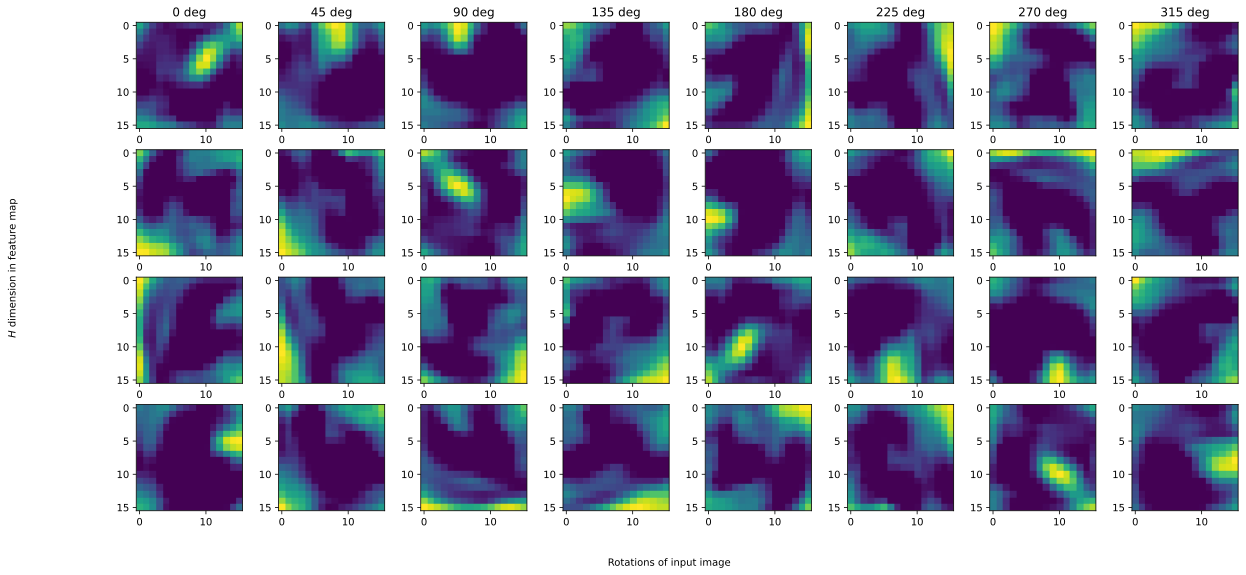

In [ ]:
plt.rcParams['figure.figsize'] = [20, 9]

# Pick a channel to visualize
channel_idx = 2

# Create a subfigure for every rotated input and every group element
fig, ax = plt.subplots(gcnn_out.shape[2], rots.numel())

for idx, rotation in enumerate(rots):
    for group_element_idx in range(gcnn_out.shape[2]):
        ax[group_element_idx ,idx].imshow(
            gcnn_out[idx, out_channel_idx, group_element_idx, :, :].detach().numpy()
        )
    ax[0, idx].set_title(f"{int(rotation)} deg")
    

fig.text(0.5, 0.04, 'Rotations of input image', ha='center')
fig.text(0.04, 0.5, '$H$ dimension in feature map', va='center', rotation='vertical')

plt.show()

We can see that indeed, save for some interpolation artefacts, the feature maps equivary with rotations that are multiples of 90 deg! These representations are equivariant to rotations of 90 degrees.

Lastly, we inspect the representations we obtain after the projection step for the CNN and GCNN. We visualize all channels. These are the representations on which the final linear layer(s) perform classification.

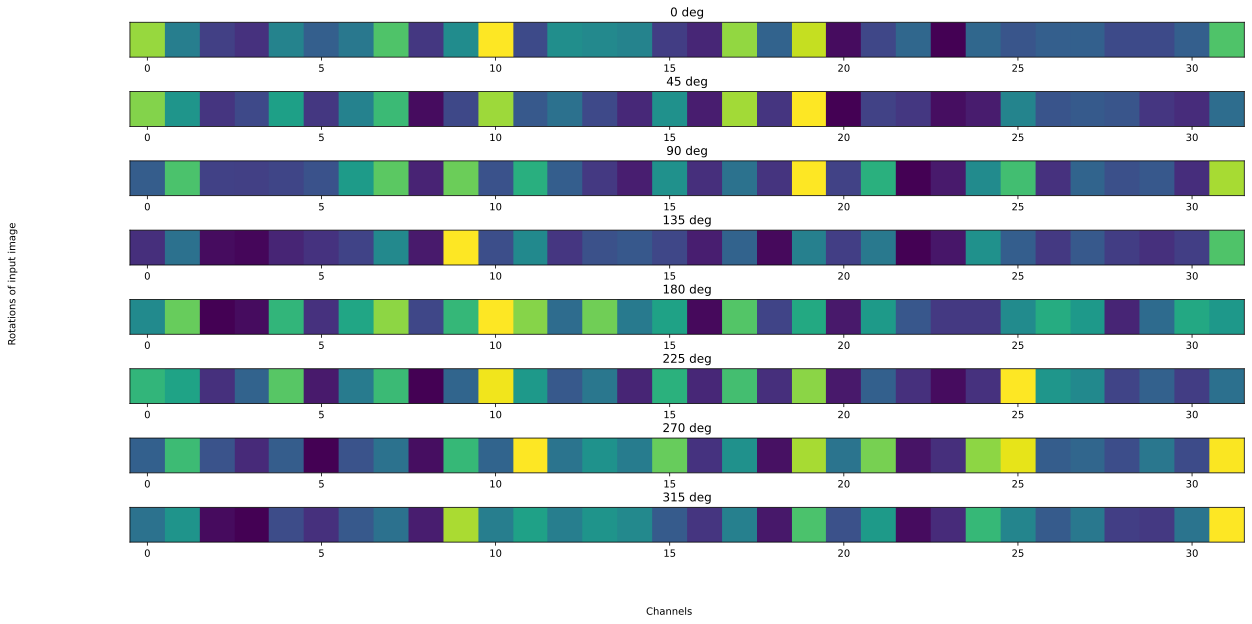

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]

# Create a subfigure for every rotated input
fig, ax = plt.subplots(rots.numel(), 1)

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        projected_cnn_out[idx, None, :].detach().numpy()
    )
    ax[idx].set_title(f"{int(rotation)} deg")
    ax[idx].set_yticks([])

fig.text(0.5, 0.04, 'Channels', ha='center')
fig.text(0.04, 0.5, 'Rotations of input image', va='center', rotation='vertical')

plt.show()

As we can see, as the input image rotates, the representations change. The representations built by the network are not invariant to rotation, and as such, the linear layers may classify them differently.

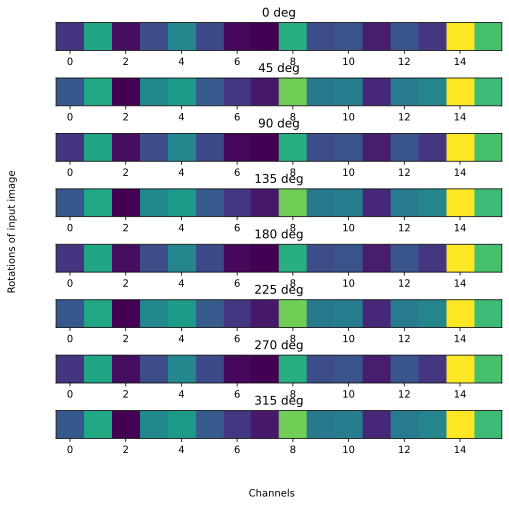

In [ ]:
plt.rcParams['figure.figsize'] = [8, 8]

# Create a subfigure for every rotated input
fig, ax = plt.subplots(rots.numel(), 1)

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        projected_gcnn_out[idx, None, :].detach().numpy()
    )
    ax[idx].set_title(f"{int(rotation)} deg")
    ax[idx].set_yticks([])

fig.text(0.5, 0.04, 'Channels', ha='center')
fig.text(0.04, 0.5, 'Rotations of input image', va='center', rotation='vertical')

plt.show()

The representations built for each of the rotated inputs is (more or less) equal! These representations *are* invariant to 90 degree rotations, and the final linear layers see them as identical!

## 4. Concluding remarks

We've seen how to implement a basic regular group convolutional network equivariant to rotations of 90 degrees. A couple suggestions of things to ponder on... Feel free to use these as starting point for a possible project you'd like to do:

*  What other groups could be interesting in computer vision problems? (these often come with their own interesting challenges). 
*  We used interpolation to obtain our values for transformed kernels. As mentioned, this makes our networks prone to interpolation artefacts. Would our interpolation implementation work well for other groups? Could you maybe think of other ways of defining the kernel over a continuous domain?
*  Here we worked with a one-dimensional group. What would it take to implement group convolutions for multidimensional groups $H$?
